In [1]:
!pip install einops
!pip install optuna
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error
import os
import pickle
import random
import torch
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import math
import sys
import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import json
import copy
import torchvision.ops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.0 MB/s eta 0:00:00


In [2]:
!git clone 'https://github.com/edwardhan925192/TimesNet.git'
%cd /content/TimesNet

from times_model import Model
from whole_dataset import TimeSeriesDataset,TimeSeries_ValDataset,TimeSeries_TestDataset
from schedular.scheduler import initialize_scheduler

Cloning into 'TimesNet'...
remote: Enumerating objects: 844, done.
remote: Counting objects: 100% (385/385), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 844 (delta 221), reused 270 (delta 156), pack-reused 459
Receiving objects: 100% (844/844), 281.87 KiB | 1.46 MiB/s, done.
Resolving deltas: 100% (482/482), done.
/content/TimesNet


In [3]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # for multi-GPU.
np.random.seed(seed)
random.seed(seed)  # Replace 42 with your chosen seed number

In [4]:
from pandas.tseries.offsets import YearEnd
from tqdm import tqdm

# validation 스플릿
def split_train_validation_timeseries(df, validation_ranges):
    '''
    takes list of validation range,
    Ex)   [(800, 900), (900, 1000)]

    returns rows previous of validation range and validation range.
    '''
    train_dfs = []
    validation_dfs = []

    for val_range in validation_ranges:
        # Ensure the range is valid
        start, end = val_range
        if start >= end or end > len(df):
            raise ValueError("Invalid range: {}".format(val_range))

        # Split the DataFrame
        validation_df = df.iloc[start:end]
        train_df = df.iloc[:start]

        train_dfs.append(train_df)
        validation_dfs.append(validation_df)

    return train_dfs, validation_dfs

# 결측치 채우기
def fill_missing_with_ratio(df, ratio, column2, column1):
    """
    If column 1 is missing, fill it by multiplying column 2 with the ratio.
    If column 2 is missing, fill it by dividing column 1 by the ratio.

    column 2 is bigger column

    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    ratio (float): The ratio to be used for filling missing values.
    column1 (str): The name of the first column.
    column2 (str): The name of the second column.

    Returns:
    pd.DataFrame: DataFrame with filled values.
    """
    if column1 not in df or column2 not in df:
        raise ValueError("Specified columns must be in the DataFrame")

    # If column1 is missing, fill it by multiplying column2 with the ratio
    df[column1] = df.apply(lambda row: row[column2] * ratio if pd.isna(row[column1]) else row[column1], axis=1)

    # If column2 is missing, fill it by dividing column1 by the ratio
    df[column2] = df.apply(lambda row: row[column1] / ratio if pd.isna(row[column2]) else row[column2], axis=1)

    return df

# 결측치 채우기2
def interpolate_columns(df, columns):
    """
    Interpolates missing values in specified columns of a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    columns (list of str): List of column names in which to interpolate missing values.

    Returns:
    pd.DataFrame: DataFrame with interpolated values in the specified columns.
    """
    for column in columns:
        if column in df.columns:
            df[column] = df[column].interpolate(method='linear', limit_direction='forward', axis=0)
        else:
            print(f"Column '{column}' not found in DataFrame.")
    return df

def convert_datetime_column(df, column_name):
    # Define a helper function to extract date-time components and differentiate between weekends and weekdays
    def extract_date_time_components(datetime_str):
        # Check if the hour component is present in the datetime string
        if ':' in datetime_str or ' ' in datetime_str and len(datetime_str.split(' ')[1]) > 0:
            dt_format = '%Y-%m-%d %H'
        else:
            dt_format = '%Y-%m-%d'

        dt_obj = datetime.strptime(datetime_str, dt_format)
        weekday = dt_obj.weekday()

        # Classify as 'Weekend' or 'Weekday'
        day_type = 'Weekend' if weekday in [5, 6] else 'Weekday'

        # Return components based on the presence of the hour component
        if dt_format == '%Y-%m-%d %H':
            return dt_obj.year, dt_obj.month, dt_obj.day, dt_obj.hour, day_type
        else:
            return dt_obj.year, dt_obj.month, dt_obj.day, None, day_type

    # Apply the helper function to the specified column
    components = df[column_name].apply(extract_date_time_components)

    # Unpack components and create columns conditionally
    df['Year'], df['Month'], df['Day'], hour_component, df['DayType'] = zip(*components)
    if any(hour is not None for hour in hour_component):
        df['Hour'] = hour_component

    return df


columns_info = {
    'Month': 12,
    'Hour': 23,
    'Day':31
}

def fill_column_from_dfB_to_dfA(dfA, dfB, column_name):
    """
    Fill values of a column in dfA with values from the same column in dfB.

    Parameters:
    dfA (pd.DataFrame): The dataframe to be updated.
    dfB (pd.DataFrame): The dataframe providing the new values.
    column_name (str): The name of the column to be updated.
    """
    # Check if the column exists in both dataframes
    if column_name in dfA.columns and column_name in dfB.columns:
        # Determine the number of rows to update
        num_rows_to_update = min(len(dfA), len(dfB))

        # Update the values in dfA from dfB
        dfA.loc[:num_rows_to_update - 1, column_name] = dfB.loc[:num_rows_to_update - 1, column_name]
    else:
        raise ValueError("Column not found in one or both dataframes")

    return dfA

In [6]:
from validation_split import split_train_validation_timeseries
train = pd.read_csv('/content/train.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

train = convert_datetime_column(train, '일시')
test = convert_datetime_column(sample_submission.drop('평균기온',axis = 1), '일시')
train = train.drop(['일시','DayType'],axis = 1)
test = test.drop(['일시','DayType'],axis = 1)

# 최고기온, 최저기온, 일교차 , 평균풍속 결측치
train_ = interpolate_columns(train,['최고기온','최저기온', '일교차' , '평균풍속'])

# 강수량 결측치
train_['강수량'] = train_['강수량'].fillna(0)

# 일조합 일조율 결측치
ratio = train[train['일조율'] > 0]['일조율'].sum() / train[train['일조율'] > 0]['일조합'].sum()
train_ = fill_missing_with_ratio(train_,ratio,'일조합','일조율')

# 일사합 결측치
train_ = train_.drop('일사합',axis =1 )
train_ = train_.drop(['평균풍속','일교차','평균풍속','일조율','Year','Month','Day'],axis = 1)
train_ = train_[['평균기온','최고기온','최저기온']]

In [7]:
# 스케줄러 설정
class SchedulerConfig:
    def __init__(self):
        # STARTS from lr goes down to eta_min in T_0
        self.CosineAnnealingWarmRestarts = {'T_0': 10, 'T_mult': 1, 'eta_min': 0.0005}
        self.StepLR = {'step_size': 10, 'gamma': 0.1}
        self.ExponentialLR = {'gamma': 0.95}

        #steps_per_epoch should be set to number of batches , epochs should be total number of epochs
        # Starts from low lr to max lr
        self.OneCycleLR = {'max_lr': 0.01, 'steps_per_epoch': 10, 'epochs': 20}

        self.CyclicLR = {'base_lr': 0.001, 'max_lr': 0.01, 'step_size_up': 5,'step_size_down':5,  'mode': 'triangular'}

    def get_params(self, scheduler_name):
        return getattr(self, scheduler_name, None)

num_features = 3
target_name = '평균기온'

# 모델 파라미터 설정
class Config:
    def __init__(self):
        self.task_name = 'short_term_forecast'
        self.seq_len = 365
        self.window_shift = 1
        self.enc_in = num_features
        self.d_model = 22
        self.top_k = 3
        self.d_ff = 22
        self.num_kernels = 6
        self.dropout = 0.24915726313968972
        self.e_layers = 1
        self.label_len = num_features
        self.target_col = target_name
        self.cnn_type = 'inceptionv1'
        self.pred_len = 358
        self.c_out = 1
        self.eval_range = 0
        self.seq_range = np.concatenate([np.arange(0, 45), np.arange(317, 358)])
        self.scheduler_config = SchedulerConfig()
        self.scheduler_name = 'CosineAnnealingWarmRestarts'
        self.scheduler_update_type = 'epoch'
    def update(self, new_params):
        for key, value in new_params.items():
            if hasattr(self, key):
                setattr(self, key, value)
winter_configs = Config()

In [8]:
class SchedulerConfig:
    def __init__(self):
        # STARTS from lr goes down to eta_min in T_0
        self.CosineAnnealingWarmRestarts = {'T_0': 10, 'T_mult': 1, 'eta_min': 0.0005}
        self.StepLR = {'step_size': 10, 'gamma': 0.1}
        self.ExponentialLR = {'gamma': 0.95}

        #steps_per_epoch should be set to number of batches , epochs should be total number of epochs
        # Starts from low lr to max lr
        self.OneCycleLR = {'max_lr': 0.01, 'steps_per_epoch': 10, 'epochs': 20}

        self.CyclicLR = {'base_lr': 0.001, 'max_lr': 0.01, 'step_size_up': 5,'step_size_down':5,  'mode': 'triangular'}

    def get_params(self, scheduler_name):
        return getattr(self, scheduler_name, None)

num_features = 3
target_name = '평균기온'

class Config:
    def __init__(self):
        self.task_name = 'short_term_forecast'
        # Output features and c_out should be the same when the task is anomaly_detection
        self.seq_len = 365
        self.window_shift = 1
        self.enc_in = num_features    # Features
        self.d_model = 20     # Convolution Embedding dimension AFTER RESHAPING
        self.top_k = 3        # FFT frequency
        self.d_ff = 20       # Convolution Output layer dimension AFTER RESHAPING
        self.num_kernels = 6  # inception block Num of different grid cells used / If using dcvn set it to 3
        self.dropout = 0.1933493411095017    # Dropout rate
        self.e_layers = 1     # num Timeblock
        self.label_len = num_features   # Features
        self.target_col = target_name   # Name of target column
        self.cnn_type = 'inceptionv1' # dcvn (KERNEL = 3), inceptionv1, inceptionv2, res_dcvn, res_inceptionv1, res_inceptionv2
        self.pred_len = 358   # Prediction length
        self.c_out = 1        # Output feature
        self.eval_range = 0
        self.seq_range = np.arange(45, 317)
        self.scheduler_config = SchedulerConfig()
        self.scheduler_name = 'CosineAnnealingWarmRestarts' #'CosineAnnealingWarmRestarts', 'StepLR', 'ExponentialLR', 'OneCycleLR', 'CyclicLR'
        self.scheduler_update_type = 'epoch' # epoch, batch
    def update(self, new_params):
        for key, value in new_params.items():
            if hasattr(self, key):
                setattr(self, key, value)

xwinter_configs = Config()

In [9]:
df_train = train_
target_col = None
learning_rate = 0.01
num_epochs = 10
batch_sizes = 30
configs = winter_configs #winter_configs, xwinter_configs
df_test = train_

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_state = None

training_loss_history = []

col_list = list(df_train.columns)
target_index = col_list.index(target_col) if target_col in col_list else -1

criterion = nn.L1Loss()

model = Model(configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = initialize_scheduler(optimizer, configs)

train_dataset = TimeSeriesDataset(df_train, configs.seq_len, configs.pred_len, configs.seq_range, configs.eval_range)
train_loader = DataLoader(train_dataset, batch_size=batch_sizes, shuffle=False)

for epoch in range(num_epochs):

    model.train()
    total_loss = 0

    for batch_idx, (batch_data, batch_target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        batch_data, batch_target = batch_data.to(device), batch_target.to(device)
        optimizer.zero_grad()
        outputs = model(batch_data)

        loss = criterion(outputs, batch_target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    average_training_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training_Loss = {average_training_loss}')
model_state = copy.deepcopy(model.state_dict())

test_dataset = TimeSeries_TestDataset(df_test, configs.seq_len)
test_loader = DataLoader(test_dataset, batch_size=batch_sizes, shuffle=False)

model.eval()

with torch.no_grad():
    for batch_test_data in test_loader:
        batch_test_data = batch_test_data.to(device)
        outputs = model(batch_test_data)

winter_pred = outputs

Epoch 1/10: 100%|██████████| 743/743 [01:27<00:00,  8.47it/s]


Epoch 1/10, Training_Loss = 3.970152026390805


Epoch 2/10: 100%|██████████| 743/743 [01:14<00:00, 10.04it/s]


Epoch 2/10, Training_Loss = 2.920176351535689


Epoch 3/10: 100%|██████████| 743/743 [01:13<00:00, 10.08it/s]


Epoch 3/10, Training_Loss = 2.778329321545515


Epoch 4/10: 100%|██████████| 743/743 [01:14<00:00, 10.00it/s]


Epoch 4/10, Training_Loss = 2.702231905662516


Epoch 5/10: 100%|██████████| 743/743 [01:15<00:00,  9.86it/s]


Epoch 5/10, Training_Loss = 2.674987894047959


Epoch 6/10: 100%|██████████| 743/743 [01:16<00:00,  9.73it/s]


Epoch 6/10, Training_Loss = 2.6254948210748337


Epoch 7/10: 100%|██████████| 743/743 [01:18<00:00,  9.51it/s]


Epoch 7/10, Training_Loss = 2.5898705488258864


Epoch 8/10: 100%|██████████| 743/743 [01:18<00:00,  9.44it/s]


Epoch 8/10, Training_Loss = 2.5583013371535617


Epoch 9/10: 100%|██████████| 743/743 [01:19<00:00,  9.40it/s]


Epoch 9/10, Training_Loss = 2.5358267830005405


Epoch 10/10: 100%|██████████| 743/743 [01:19<00:00,  9.38it/s]

Epoch 10/10, Training_Loss = 2.5183537620875587


In [11]:
configs = xwinter_configs

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_state = None

training_loss_history = []

col_list = list(df_train.columns)
target_index = col_list.index(target_col) if target_col in col_list else -1

criterion = nn.L1Loss()

model = Model(configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = initialize_scheduler(optimizer, configs)

train_dataset = TimeSeriesDataset(df_train, configs.seq_len, configs.pred_len, configs.seq_range, configs.eval_range)
train_loader = DataLoader(train_dataset, batch_size=batch_sizes, shuffle=False)

for epoch in range(num_epochs):

    model.train()
    total_loss = 0

    for batch_idx, (batch_data, batch_target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        batch_data, batch_target = batch_data.to(device), batch_target.to(device)
        optimizer.zero_grad()
        outputs = model(batch_data)

        loss = criterion(outputs, batch_target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    average_training_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training_Loss = {average_training_loss}')
model_state = copy.deepcopy(model.state_dict())

test_dataset = TimeSeries_TestDataset(df_test, configs.seq_len)
test_loader = DataLoader(test_dataset, batch_size=batch_sizes, shuffle=False)

model.eval()

with torch.no_grad():
    for batch_test_data in test_loader:
        batch_test_data = batch_test_data.to(device)
        outputs = model(batch_test_data)


xwinter_pred = outputs

Epoch 1/10: 100%|██████████| 743/743 [01:18<00:00,  9.48it/s]


Epoch 1/10, Training_Loss = 3.3830284610250274


Epoch 2/10: 100%|██████████| 743/743 [01:10<00:00, 10.57it/s]


Epoch 2/10, Training_Loss = 2.9306187908870855


Epoch 3/10: 100%|██████████| 743/743 [01:10<00:00, 10.51it/s]


Epoch 3/10, Training_Loss = 2.840054847350191


Epoch 4/10: 100%|██████████| 743/743 [01:08<00:00, 10.77it/s]


Epoch 4/10, Training_Loss = 2.795237944552908


Epoch 5/10: 100%|██████████| 743/743 [01:08<00:00, 10.84it/s]


Epoch 5/10, Training_Loss = 2.738656392328511


Epoch 6/10: 100%|██████████| 743/743 [01:08<00:00, 10.81it/s]


Epoch 6/10, Training_Loss = 2.6958463538543374


Epoch 7/10: 100%|██████████| 743/743 [01:09<00:00, 10.65it/s]


Epoch 7/10, Training_Loss = 2.6588890887847016


Epoch 8/10: 100%|██████████| 743/743 [01:10<00:00, 10.57it/s]


Epoch 8/10, Training_Loss = 2.6109665502288943


Epoch 9/10: 100%|██████████| 743/743 [01:10<00:00, 10.55it/s]


Epoch 9/10, Training_Loss = 2.574353535916571


Epoch 10/10: 100%|██████████| 743/743 [01:10<00:00, 10.52it/s]


Epoch 10/10, Training_Loss = 2.548677317387002


In [12]:
first = winter_pred[0][:45].cpu()
third = winter_pred[0][45:].cpu()

second = xwinter_pred[0].cpu()

full_pred = np.concatenate([first.numpy(), second.numpy(), third.numpy()], axis=0)

In [15]:
result = pd.DataFrame(full_pred)
result.columns = ['평균기온']
submission_A = fill_column_from_dfB_to_dfA(sample_submission,result,'평균기온')
submission_A.to_csv('/content/submission.csv',index = False)

<ipython-input-21-ddacf177b033>:16: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ddacf177b033>:16: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ddacf177b033>:16: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ddacf177b033>:16: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ddacf177b033>:16: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ddacf177b033>:16: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ddacf177b033>:16: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  plt.tight_layout()
<ipython-input-21-ddacf177b033>:16: UserWarning: Glyp

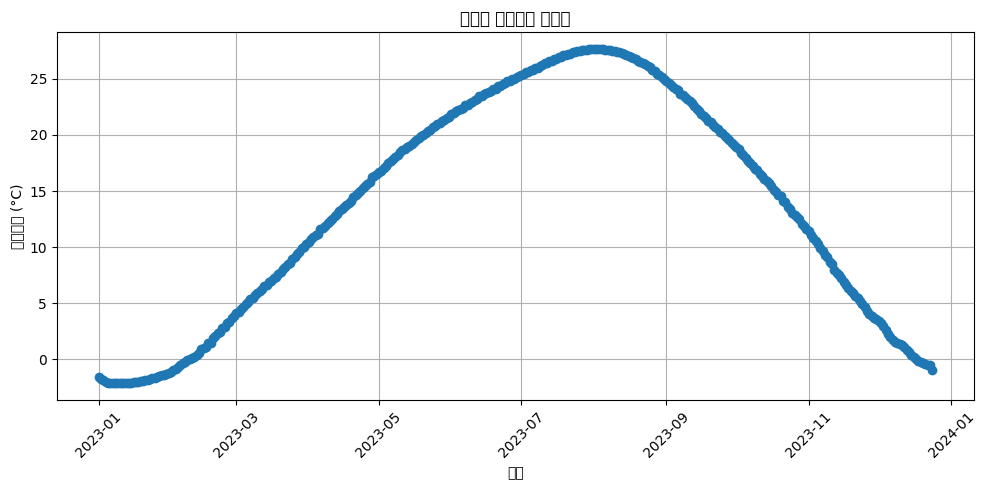

In [21]:
import matplotlib.pyplot as plt

submission = pd.read_csv('/content/submission.csv')
submission

submission['일시'] = pd.to_datetime(submission['일시'])

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(submission['일시'], submission['평균기온'], marker='o')
plt.title('일시별 평균기온 그래프')
plt.xlabel('일시')
plt.ylabel('평균기온 (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-22-2975c44636c9>:16: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
<ipython-input-22-2975c44636c9>:16: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.tight_layout()
<ipython-input-22-2975c44636c9>:16: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  plt.tight_layout()
<ipython-input-22-2975c44636c9>:16: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  plt.tight_layout()
<ipython-input-22-2975c44636c9>:16: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
<ipython-input-22-2975c44636c9>:16: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  plt.tight_layout()
<ipython-input-22-2975c44636c9>:16: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  plt.tight_layout()
<ipython-input-22-2975c44636c9>:16: UserWarning: Glyp

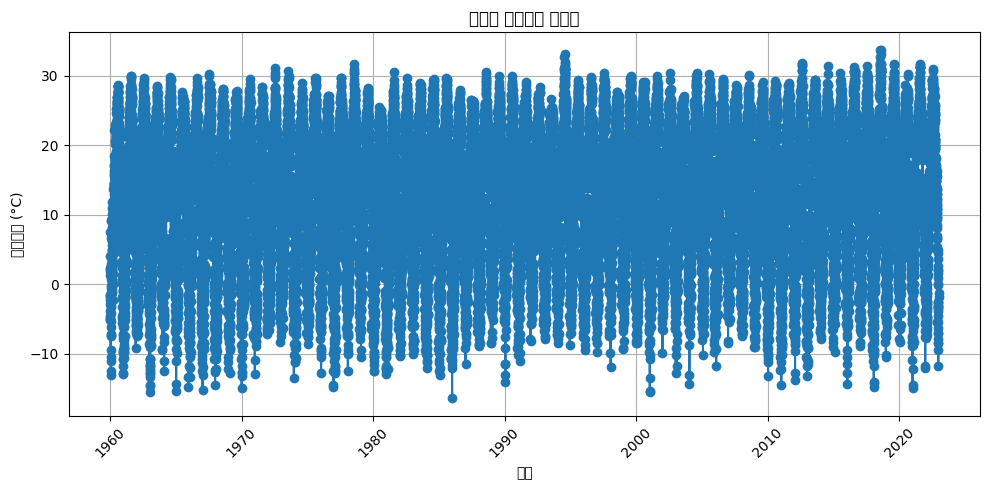

In [22]:
import matplotlib.pyplot as plt

submission = pd.read_csv('/content/train.csv')
submission

submission['일시'] = pd.to_datetime(submission['일시'])

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(submission['일시'], submission['평균기온'], marker='o')
plt.title('일시별 평균기온 그래프')
plt.xlabel('일시')
plt.ylabel('평균기온 (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()